In [1]:
from sklearn import datasets
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.animation import FuncAnimation, PillowWriter

## Abstract

In this we try to apply DDPM to a very simple problem

The dataset is called Swiss roll, where each data point is a 2D-point from a Swiss roll distribution, as shown below

We will apply forward diffusion and try to learn the backward path through the use of DDPM

## Data generation and Forward diffusion

In [2]:
X, t = datasets.make_swiss_roll(n_samples=1000, noise=0.1)
X = X[:,[0,2]]

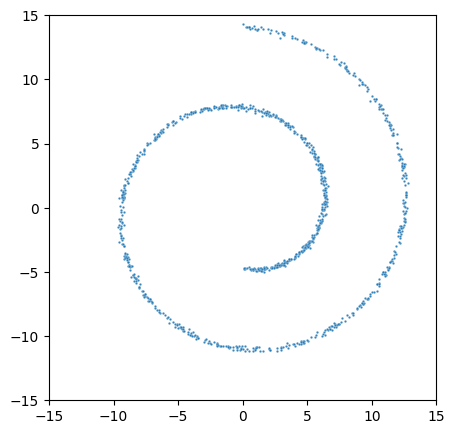

In [3]:
fig = plt.figure(figsize=(5,5))
sns.scatterplot(x=X[:,0], y=X[:,1], s=3, alpha=0.9)
plt.xlim(-15,15)
plt.ylim(-15,15)
plt.show()

In [4]:
T = 40
beta = np.linspace(0.0001, 0.2, T)
Xt = X
Xt_history = [Xt]

for i in range(T):
    Z = np.random.randn(*X.shape)
    Xt = np.sqrt(1-beta[i])*Xt + np.sqrt(beta[i])*Z
    Xt_history.append(Xt)

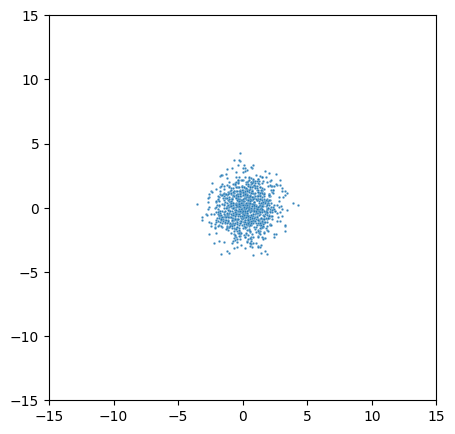

In [5]:
fig = plt.figure(figsize=(5,5))
sns.scatterplot(x=Xt[:,0], y=Xt[:,1], s=3, alpha=0.9)
plt.xlim(-15,15)
plt.ylim(-15,15)
plt.show()

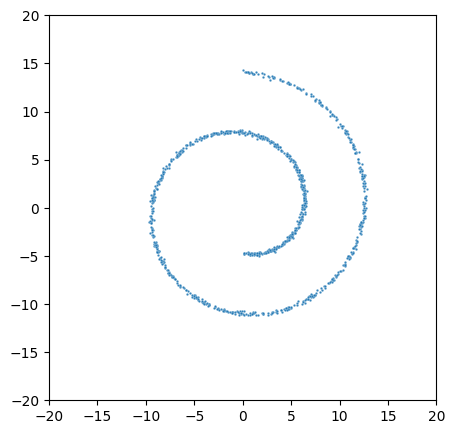

In [6]:
# create gif of images evolving over time, based on Xt_history
def animate_diff(i, Xt_history):
    plt.cla()
    # plots = sns.kdeplot(x=Xt_history[i][:,0], y=Xt_history[i][:,1], fill=True, cmap="viridis")
    plots = sns.scatterplot(x=Xt_history[i][:,0], y=Xt_history[i][:,1], s=3, alpha=0.9)
    plots.set_xlim(-20, 20)
    plots.set_ylim(-20, 20)
    return plots

fig = plt.figure(figsize=(5,5))
plt.clf()

ani = FuncAnimation(
    fig,
    animate_diff,
    fargs=[Xt_history],
    interval=200,
    blit=False,
    repeat=True,
    frames=len(Xt_history),
)
ani.save(
    f"gif_2d_swiss_roll.gif",
    dpi=100,
    writer=PillowWriter(fps=5),
)

## Reverse diffusion

In [1]:
import torch
from torch import nn
import tqdm
import wandb

from sklearn import datasets
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.animation import FuncAnimation, PillowWriter

In [12]:
class ResBlock(nn.Module):
    def __init__(self, dim, hidden_units):
        super(ResBlock, self).__init__()
        self.layer = nn.Sequential(
            nn.Linear(dim, hidden_units),
            nn.GELU(),
            nn.Linear(hidden_units, dim),
            nn.GELU()
        )

    def forward(self, x):
        x_skip = x
        x = self.layer(x)
        return x + x_skip

class Model(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_units):
        super(Model, self).__init__()

        self.t_emb = nn.Sequential(
            nn.Linear(1, hidden_units), 
            nn.GELU()
        )
        
        self.layer= nn.Sequential(
            nn.Linear(input_dim, hidden_units),
            nn.GELU()
        )

        self.resblock1 = ResBlock(hidden_units, hidden_units)
        self.resblock2 = ResBlock(hidden_units, hidden_units)
        self.resblock3 = ResBlock(hidden_units, hidden_units)
        
        self.out = nn.Linear(hidden_units, output_dim)

    def forward(self, x, t):
        t = t.view(-1,1)
        t = self.t_emb(t)

        x = self.layer(x)
        x = x + t

        x = self.resblock1(x)
        x = self.resblock2(x)
        x = self.resblock3(x)

        x = self.out(x)
        return x

In [13]:
# X, t = datasets.make_swiss_roll(n_samples=100000, noise=0.1)
# X = X[:,[0,2]]
# np.save("swiss_roll.npy", X, allow_pickle=True)

In [14]:
# load data
X = np.load("swiss_roll.npy")

# select 10000 lines
X = X[:20000, :]

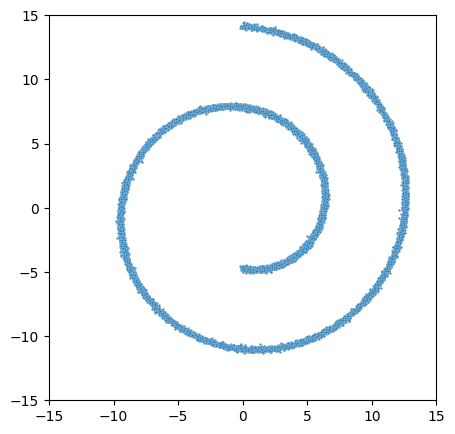

In [15]:
fig = plt.figure(figsize=(5,5))
sns.scatterplot(x=X[:,0], y=X[:,1], s=3, alpha=0.9)
plt.xlim(-15,15)
plt.ylim(-15,15)
plt.show()

In [17]:
T = 400
epochs = 10000
lrate = 1e-4
n_feat = 64
device ="cuda"
beta1, beta2 = 0.001, 0.2

beta = torch.linspace(beta1, beta2, T+1).to(device)
alpha = 1-beta
alpha_cum = torch.cumprod(alpha, dim=0)
X_torch = torch.from_numpy(X).float().to(device)

In [18]:
model = Model(2, 2, n_feat).to(device)

total_params = sum([p.numel() for p in model.parameters()])
print("Model initialized, total params = ", total_params)

Model initialized, total params =  25410


In [19]:
mse = nn.MSELoss()
optim = torch.optim.Adam(model.parameters(), lr=lrate)

In [20]:
wandb.init(
        project="2D Swiss roll",
        config={
            "learning_rate": lrate,
            "epochs": epochs,
            "num_features": n_feat,
            "beta1": beta1,
            "beta2": beta2,
            "T": T,
            "device":device,
        },
    )

pbar = tqdm.tqdm(range(epochs))
loss_ema = None

model.train()
for i in pbar:
    optim.zero_grad()
    
    t = torch.randint(1, T+1, (X_torch.shape[0],)).to(device)
    Z = torch.randn_like(X_torch).to(device)
    scaling = alpha_cum[t].view(-1,1)
    Xt = torch.sqrt(scaling)*X_torch + torch.sqrt(1-scaling)*Z
    
    noise_pred = model(Xt, t/T)
    loss = mse(noise_pred, Z)

    wandb.log({"loss": loss.item()})
    
    if loss_ema is None:
        loss_ema = loss.item()
    else:
        loss_ema = 0.95 * loss_ema + 0.05 * loss.item()

    if loss.item() < 0.000005:
        break
        
    pbar.set_description(f"loss: {loss_ema:.4f}")

    loss.backward()
    optim.step()
    
    optim.param_groups[0]["lr"] = lrate * (1 - i / epochs)
    

loss,▃▅█▆▆▃▄▄▃▅▄▁▂▅▅▅▄▄▂▇▃▃▃▂▇▅▄▃▄▂▄▄▃▄▆▃▄▃▄▅
loss,0.20974


loss: 0.2191: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:26<00:00, 379.97it/s]


In [21]:
model.eval()

xi = torch.randn_like(X_torch).to(device)
Xs_history = [xi.detach().cpu()]

for t in tqdm.tqdm(reversed(range(T))):
    ti = torch.tensor([i / T]).to(device)
    ti = ti.repeat(X_torch.shape[0], 1)

    noise_pred = model(xi, ti)
    z = torch.randn_like(X_torch).to(device)
    if i <= 1:
        z = 0

    # ancestral sampling
    xi = (
        1/torch.sqrt(alpha[t]) * (xi - noise_pred * (1-alpha[t])/(torch.sqrt(1-alpha_cum[t])))
        + torch.sqrt(beta[t]) * z
    )
    if t%10 == 0 or t<20:
        Xs_history.append(xi.detach().cpu().numpy())

313it [00:00, 529.69it/s]


OutOfMemoryError: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 

In [40]:
Xs = xi.detach().cpu().numpy()

In [41]:
Xs

array([[-3.8786607,  9.345332 ],
       [-3.8737822,  7.502439 ],
       [-4.8115644,  8.50994  ],
       ...,
       [-4.025158 ,  8.498749 ],
       [-4.807929 ,  9.4307995],
       [-3.9226556,  8.4100485]], dtype=float32)

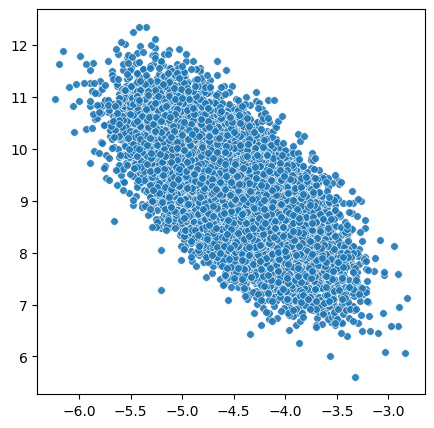

In [42]:
fig = plt.figure(figsize=(5,5))
sns.scatterplot(x=Xs[:,0], y=Xs[:,1], s=30, alpha=0.9)
# plt.xlim(-15,15)
# plt.ylim(-15,15)
plt.show()

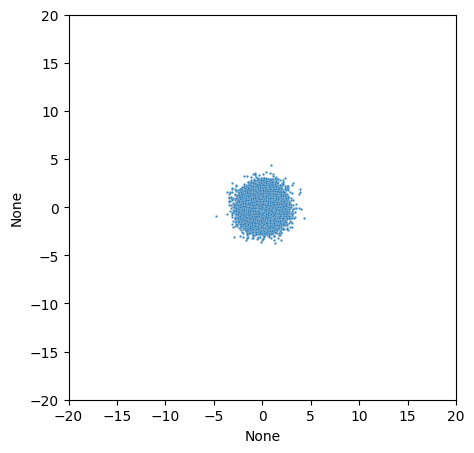

In [21]:
# create gif of images evolving over time, based on Xt_history
def animate_diff(i, Xt_history):
    plt.cla()
    # plots = sns.kdeplot(x=Xt_history[i][:,0], y=Xt_history[i][:,1], fill=True, cmap="viridis")
    plots = sns.scatterplot(x=Xt_history[i][:,0], y=Xt_history[i][:,1], s=3, alpha=0.9)
    plots.set_xlim(-20, 20)
    plots.set_ylim(-20, 20)
    return plots

fig = plt.figure(figsize=(5,5))
plt.clf()

ani = FuncAnimation(
    fig,
    animate_diff,
    fargs=[Xs_history],
    interval=200,
    blit=False,
    repeat=True,
    frames=len(Xs_history),
)
ani.save(
    f"gif_2d_swiss_roll_gen.gif",
    dpi=100,
    writer=PillowWriter(fps=5),
)